In [80]:
# Dependency parsing and coreference resolution 
import spacy
from spacy import displacy
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
from sklearn import tree

In [2]:
def retokenize_entities(doc):

    # Step 1: Identify Multi-Word Named Entities
    multi_word_entities = []
    for ent in doc.ents:
        if len(ent) > 1:
            multi_word_entities.append(ent)

    # Step 2: Merge Tokens
    for ent in multi_word_entities:
        with doc.retokenize() as retokenizer:
            start = ent.start
            end = ent.end
            retokenizer.merge(doc[start:end])

def format_relations(relations):
    sent_dic = {}

    for key in relations:
        for ref in relations[key]:
            if ref not in sent_dic:
                sent_dic[ref] = [key]
            else:
                sent_dic[ref].append(key)

    for key, value in sent_dic.items():
        sent_dic[key] = sorted(value)

    return sent_dic            

# Uses displacy to visualize a sentences dependency tree 

def visualize_dependency_tree(doc):
    
    # Visualize the dependency tree
    displacy.render(doc, style="dep")

In [26]:
def find_dependency_paths(sentence, from_pos, to_pos):   

    # Find all paths from the rot to adjectives in the tree
    all_paths = []
    mark_down(sentence.root, [], all_paths, to_pos)
        
    # store paths from each node to the adjectives below it 
    mem = [[] for _ in range(len(sentence))]

    for path in all_paths:
        for index, p in enumerate(path):
            num_token = p[0] 
            mem[num_token].append(path[index:]) 
    
    relevant_paths = []

    # add paths from the POS specified to the second POS specified. Consider paths that intially stem upward as well 
    find_paths(sentence.root, relevant_paths, from_pos, mem)

    return relevant_paths




def find_paths(token, relevant_paths, from_pos, mem):

    if token.pos_ in from_pos:
        relevant_paths += mem[token.i]

        # set current token and define first element of upard path 
        curr = token
        upward_path = [[curr.i,curr.pos_,curr.dep_, "UP"]]
        # iterate while the parent can be accessed 
        while curr.dep_ != "ROOT":
            # define parent and the path stemming from it (obtained from mem)
            parent = curr.head
            alt_paths = mem[parent.i]
            # include paths stemming from parent that don't overlap with curr
            for path in alt_paths:
                # length = 1 meaning it is a to_pos or path[1][0] check to see if it leads into curr
                if len(path) == 1 or path[1][0] != curr.i:
                    combined_up_down = upward_path + path
                    relevant_paths.append(combined_up_down)
            # update upward path 
            upward_path.append([parent.i,parent.pos_, parent.dep_, "UP"])
            curr = parent

    
    # traverse remainder of the tree 
    for child in token.children:
        find_paths(child, relevant_paths, from_pos, mem)




def mark_down(token, path, all_paths, to_pos):

    path.append([token.i,token.pos_, token.dep_, "DOWN"])  
    if token.pos_ in to_pos:
        all_paths.append(path[:])  # Append a copy of the path to avoid reference issues
    # Recursive calls
    for child in token.children:
        mark_down(child, path, all_paths, to_pos)

    # Backtrack to explore another path
    path.pop()
            

In [60]:
document = "Hello my name is Manuel and I am very passionate about several things unlike my friend Harry who is a very stale and boring person."
# Load spaCy model for English
nlp = spacy.load("en_core_web_sm")
# Process the input sentence
doc = nlp(document)
retokenize_entities(doc)

visualize_dependency_tree(doc)

In [59]:
dep_types = {dep: idx for idx, dep in enumerate(nlp.get_pipe("parser").labels)}

In [53]:
def encode_path(path):
    encoded_path = []
    for dep in path:
        if dep == "DOWN":
            encoded_path.append(-1)
        elif dep == "UP":
            encoded_path.append(-2)
        else:
            encoded_path.append(dep_types[dep])
    return encoded_path

In [69]:
def getEncodedPath(document, dep_types):
    # Load spaCy model for English
    nlp = spacy.load("en_core_web_sm")
    # Process the input sentence
    doc = nlp(document)
    retokenize_entities(doc)

    # Find dependency paths 
    for sentence in doc.sents:
        paths = find_dependency_paths(sentence, ["NOUN"], ["ADJ"])

    # reformat paths for ease in processing training data 
    formatted_paths = []
    for path in paths: 
        relation = [sentence[path[0][0]].text, sentence[path[len(path) - 1][0]].text]
        temp_path = []
        for node in path:
            temp_path.append(node[2])
            temp_path.append(node[3])
        formatted_paths.append([relation, temp_path])

    # encode dependency paths 
    for path in formatted_paths:
        path[1] = encode_path(path[1])

    return formatted_paths
        
    

In [70]:
# test path encoder
paths = getEncodedPath(document, dep_types)
for p in paths: 
    print(p)

[['name', 'passionate'], [29, -2, 0, -1, 15, -1, 2, -1]]
[['name', 'several'], [29, -2, 0, -1, 15, -1, 2, -1, 39, -1, 35, -1, 6, -1]]
[['name', 'stale'], [29, -2, 0, -1, 15, -1, 2, -1, 39, -1, 35, -1, 43, -1, 8, -1, 6, -1]]
[['name', 'boring'], [29, -2, 0, -1, 15, -1, 2, -1, 39, -1, 35, -1, 43, -1, 8, -1, 6, -1, 15, -1]]
[['things', 'several'], [35, -1, 6, -1]]
[['things', 'stale'], [35, -1, 43, -1, 8, -1, 6, -1]]
[['things', 'boring'], [35, -1, 43, -1, 8, -1, 6, -1, 15, -1]]
[['things', 'passionate'], [35, -2, 39, -2, 2, -1]]
[['friend', 'several'], [35, -2, 39, -2, 35, -1, 6, -1]]
[['friend', 'stale'], [35, -2, 39, -2, 35, -1, 43, -1, 8, -1, 6, -1]]
[['friend', 'boring'], [35, -2, 39, -2, 35, -1, 43, -1, 8, -1, 6, -1, 15, -1]]
[['friend', 'passionate'], [35, -2, 39, -2, 35, -2, 39, -2, 2, -1]]
[['person', 'stale'], [8, -1, 6, -1]]
[['person', 'boring'], [8, -1, 6, -1, 15, -1]]
[['person', 'several'], [8, -2, 43, -2, 35, -1, 6, -1]]
[['person', 'passionate'], [8, -2, 43, -2, 35, -2, 3

In [67]:
import json

# Load JSON data from the file
with open('POS/POS_DecesionTree.json', 'r') as file:
    train_data = json.load(file)

In [68]:
print(train_data)

{'0': {'sentence': 'Mary is smart and kind but Monica is pessimistic.', 'pairs': [[['Mary', 'smart'], 1], [['Mary', 'kind'], 1], [['Mary', 'pessimistic'], 0], [['Monica', 'smart'], 0], [['Monica', 'kind'], 0], [['Monica', 'pessimistic'], 1]]}, '1': {'sentence': 'John is a diligent and hardworking student.', 'pairs': [[['John', 'diligent'], 1], [['John', 'hardworking'], 1], [['student', 'diligent'], 0], [['student', 'hardworking'], 0]]}, '2': {'sentence': 'The cake is delicious but too sweet.', 'pairs': [[['cake', 'delicious'], 1], [['cake', 'sweet'], 1]]}, '3': {'sentence': 'Lisa is creative and innovative in her designs.', 'pairs': [[['Lisa', 'creative'], 1], [['Lisa', 'innovative'], 1], [['designs', 'creative'], 0], [['designs', 'innovative'], 0]]}, '4': {'sentence': 'Tom is tall and athletic while Jerry is short.', 'pairs': [[['Tom', 'tall'], 1], [['Tom', 'athletic'], 1], [['Tom', 'short'], 0], [['Jerry', 'tall'], 0], [['Jerry', 'athletic'], 0], [['Jerry', 'short'], 1]]}, '5': {'sen

Training Pipeline: 
1. For each sentence in the training set find all dependency paths and store them with their label in a data frame 

In [72]:
# Associate paths with labels 
X = []
y = []

for val in train_data.values():
    paths = getEncodedPath(val['sentence'], dep_types)

    # Create a dictionary from the dependency paths
    relations = {tuple(pair[0]): pair[1] for pair in paths}

    for pair in val['pairs']:
        relation_train = tuple(pair[0])
        if relation_train in relations:
            X.append(relations[relation_train])
            y.append(pair[1])


In [77]:
print(X)
print(y)

[[8, -1, 6, -1], [8, -1, 6, -1, 15, -1], [29, -2, 0, -1, 2, -1], [29, -2, 0, -1, 2, -1, 15, -1], [35, -2, 39, -2, 15, -2, 2, -1], [35, -2, 39, -2, 15, -1], [29, -2, 0, -1, 2, -1], [29, -2, 0, -1, 15, -1, 2, -1], [29, -2, 15, -2, 0, -1, 2, -1], [29, -2, 15, -1, 2, -1], [35, -2, 39, -2, 2, -1], [35, -2, 39, -2, 2, -1, 15, -1], [29, -2, 0, -1, 2, -1], [29, -2, 0, -1, 2, -1, 15, -1], [35, -2, 39, -2, 15, -2, 2, -1], [35, -2, 39, -2, 15, -1], [29, -2, 0, -1, 2, -1], [29, -2, 0, -1, 2, -1, 15, -1], [28, -2, 0, -1, 2, -1], [28, -2, 0, -1, 2, -1, 15, -1], [8, -1, 6, -1], [8, -1, 6, -1, 15, -1], [29, -2, 0, -1, 2, -1], [29, -2, 0, -1, 2, -1, 15, -1], [29, -2, 0, -1, 2, -1], [29, -2, 0, -1, 15, -1, 2, -1], [29, -2, 15, -2, 0, -1, 2, -1], [29, -2, 15, -1, 2, -1], [29, -2, 0, -1, 2, -1], [29, -2, 0, -1, 2, -1, 15, -1], [35, -2, 39, -2, 15, -2, 2, -1], [29, -2, 0, -1, 2, -1], [29, -2, 0, -1, 2, -1, 15, -1], [29, -2, 0, -1, 2, -1], [29, -2, 0, -1, 2, -1], [29, -2, 0, -1, 2, -1], [29, -2, 0, -1, 2, -

In [79]:
# put decison tree together 
mlb = MultiLabelBinarizer()
X_enc = mlb.fit_transform(X)

clf = DecisionTreeClassifier()
clf.fit(X_enc, y)

DecisionTreeClassifier()

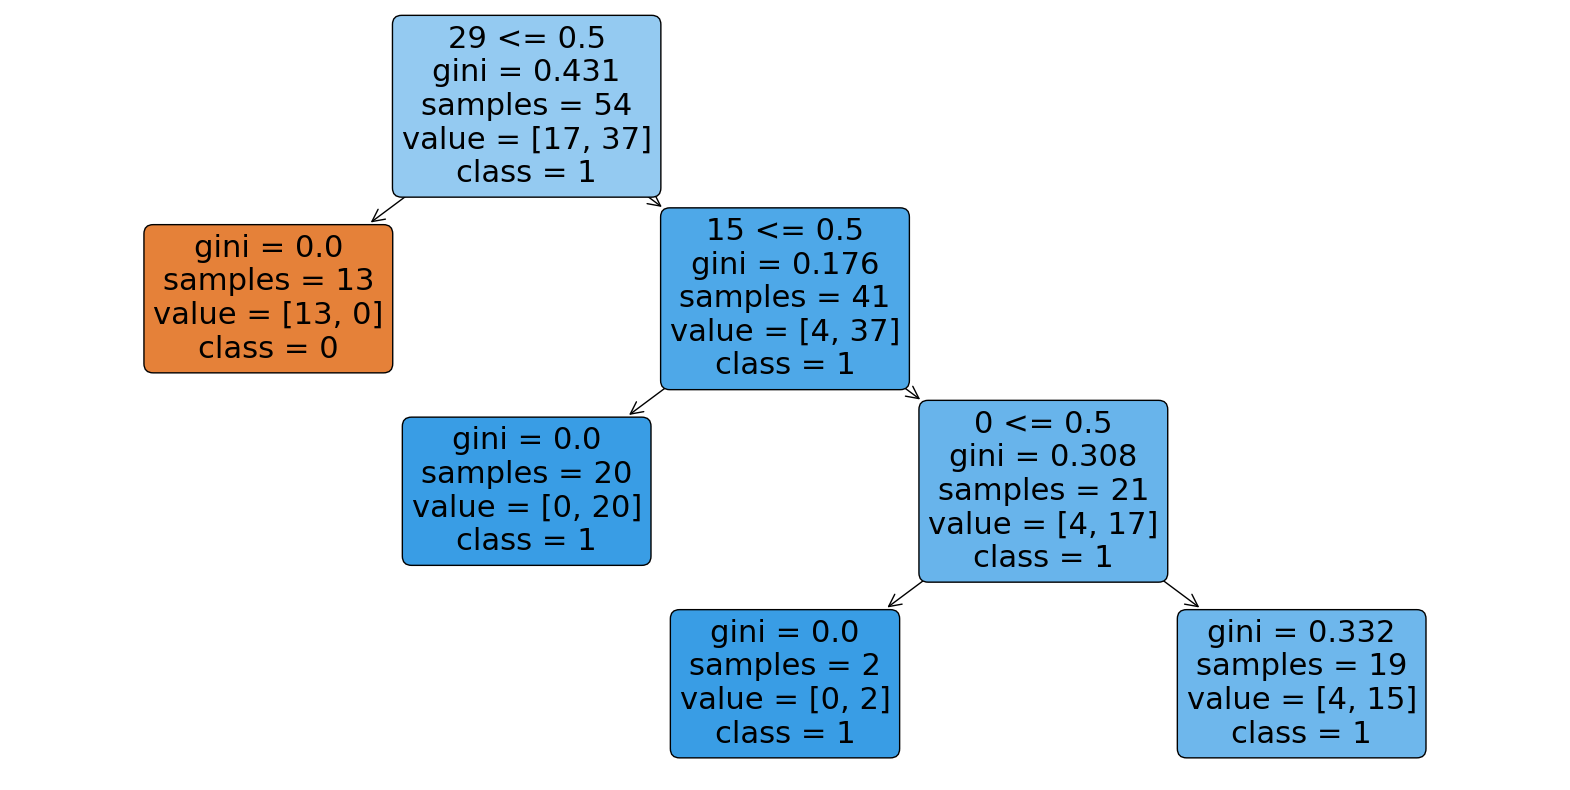

In [81]:
# Plot the decision tree
plt.figure(figsize=(20,10))
tree.plot_tree(clf, filled=True, rounded=True, feature_names=mlb.classes_, class_names=["0", "1"])
plt.show()

In [86]:
test_sentence = "The couch is green and the sofa is red but above all else the house is blue."
paths = getEncodedPath(test_sentence, dep_types)

for p in paths: 
    dep_path = p[1]
    test_X_enc = mlb.transform([dep_path])
    prediction = clf.predict(test_X_enc)
    print(p[0], prediction)

['couch', 'green'] [1]
['couch', 'red'] [1]
['couch', 'blue'] [1]
['sofa', 'red'] [1]
['sofa', 'blue'] [1]
['sofa', 'green'] [1]
['house', 'blue'] [1]
['house', 'red'] [1]
['house', 'green'] [1]


/usr/local/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:878: UserWarning: unknown class(es) [13] will be ignored
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:878: UserWarning: unknown class(es) [13] will be ignored
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:878: UserWarning: unknown class(es) [13] will be ignored
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:878: UserWarning: unknown class(es) [13] will be ignored
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:878: UserWarning: unknown class(es) [13] will be ignored
  warnings.warn(
